In [1]:
from numpy import mean, std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.models import Sequential
# from keras.optimizers import SGD
from tensorflow.keras.layers import MaxPooling2D,Activation,Flatten,Dropout,Dense,Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt




# New Section

In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpus
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-06-22 16:14:35.574917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:14:35.620277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:14:35.620718: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:14:35.625937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 16:14:35.626321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

In [3]:
(train_images, trainY), (testX, testY) = tf.keras.datasets.fashion_mnist.load_data()
print(train_images.shape)
# print(trainY.shape)
# print(testY.shape)

print(train_images.min(), train_images.max())

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
0 255


In [4]:
def reshape_data(imageX, label):
  images = imageX.reshape(-1, 28, 28, 1).astype('float32')
  #normalizing values in [-1, 1]
  images = (imageX - 127.5) / 127.5  
  y = to_categorical(label)

  # plt.imshow(images[19,:,:,0])
  return images, y


train_images, trainY = reshape_data(train_images, trainY)
testX ,testY= reshape_data(testX,testY)
print(train_images.shape, testX.shape, testY.shape )

(60000, 28, 28) (10000, 28, 28) (10000, 10)


In [5]:

# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]


inputShape=[28,28,1]
chanDim = 1
classes=10


def define_model_FID():
  model = Sequential()
  model.add( Conv2D(32, (3, 3),  padding="same",  input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))


  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))


  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='softmax'))
  return model
###################

In [6]:
opt = 'adam'
model = define_model_FID()
model.summary()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                        

In [7]:
fit = model.fit(train_images, trainY, epochs=10,batch_size=32, validation_data=(testX, testY),verbose=0)

2022-06-22 16:15:25.250480: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


In [8]:
_, acc = model.evaluate(testX, testY, verbose=0)
print('> %.3f' % (acc * 100.0))

> 93.410


[0.8396499752998352, 0.8901833295822144, 0.9005333185195923, 0.9077000021934509, 0.9174500107765198, 0.9228000044822693, 0.9285333156585693, 0.9295499920845032, 0.9339500069618225, 0.9385166764259338]


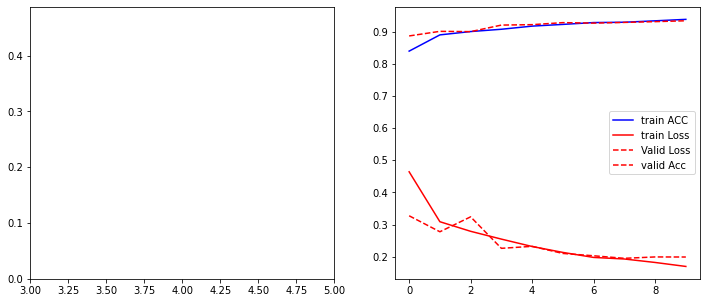

In [9]:
import numpy as np
fig,AX=plt.subplots(1,2,figsize=(12,5.))
ax=AX[0]

print(fit.history['accuracy'])
plt.plot(fit.history['accuracy'],"b",label="train ACC")
plt.plot(fit.history['loss'],"r",label="train Loss")
plt.plot(fit.history['val_loss'],"r--",label="Valid Loss")
plt.plot(fit.history['val_accuracy'],"r--",label="valid Acc")


ax.set_xlim([3, 5])
ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])


plt.legend()

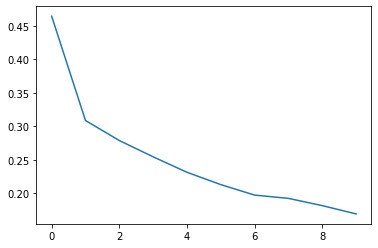

In [10]:
plt.plot(fit.history['loss'])
model.save('FID_model_trained.h5')